In [1]:
import pandas as pd

#open files
pa_data = pd.read_csv("Pseudomonas_aeruginosa.csv", delimiter =';')
sa_data = pd.read_csv("Staphylococcus_aureus.csv", delimiter =';')
pa_data[["Smiles", "Molecular Weight", "Standard Type", "Standard Relation","Standard Value", "Standard Units"]]

,Smiles,Molecular Weight,Standard Type,Standard Relation,Standard Value,Standard Units
0,CC(=O)NC[C@@H]1CN(c2ccc(N3CCOCC3)c(F)c2)C(=O)O1,337.35,MIC,'>',10000.0,nM
1,Cc1cscc1C(=O)Nc1ncnn1C,222.27,MIC,'>',300000.0,nM
2,Cl.Cl.N=C(N)Nc1ccc(-c2ccc(-c3ccc(N=C(N)N)c(Cl)...,476.20,MIC,'>',10000.0,nM
3,COc1cccc(/C=C/c2ccc(C(=O)Nc3cc(C(=O)Nc4cc(C(=O...,738.76,MIC,'>',32.0,ug.mL-1
4,C#CCN(C)c1nc(N)c(C#N)c(-c2ccccc2)c1C#N,287.33,MIC,'>',32.0,ug.mL-1
...,...,...,...,...,...,...
1087,Oc1cccc(C(Nc2nccs2)c2ccc3cccnc3c2O)c1,349.42,MIC,'>',20000.0,nM
1088,COCc1c(C(C)C)nc(C(C)C)c(/C=C/[C@@H](O)C[C@@H](...,481.54,MIC,'>',10000.0,nM
1089,CCc1nnc(NC(=O)c2cc(OC)ccn2)s1,264.31,MIC,'>',300000.0,nM
1090,CNC(=O)C1CCN(C(=O)Nc2ccc(C)c(Cl)c2)C1,295.77,MIC,'>',300000.0,nM


In [2]:
activity_treshold = 50000 #50 uM = 50000 nM
#convert ug/mL to nM
def convert_ug_to_nM(df):
    #drop rows with no mw
    no_mw = df.index[df['Molecular Weight'] == 'None'].tolist()
    df = df.drop(no_mw)
    #drop rows with no smiles
    no_smiles = df.index[df['Smiles'].astype(str) == "nan"].tolist()
    df = df.drop(no_smiles)
    df_ug = df.index[df['Standard Units'] == 'ug.mL-1'].tolist()
    for i in df_ug:
        mol_weight = float(df.loc[i]["Molecular Weight"])
        nM = float(df.loc[i]["Standard Value"])/mol_weight*10**6
        df.at[i, "Standard Value"] = nM
        df.at[i, "Standard Units"] ="nM"
    return df

def addActivity(df):
    not_greater = (df['Standard Relation'] != "'>'").tolist()
    below_treshold = (df['Standard Value'].astype(float) <= activity_treshold).tolist()
    #print(not_greater)
    active =  [int(not_greater[i] and below_treshold[i]) for i in range(len(below_treshold))]
    df['Active'] = active
    return df
                                                    

pa_data = convert_ug_to_nM(pa_data)
sa_data = convert_ug_to_nM(sa_data)
pa_data = addActivity(pa_data)
sa_data = addActivity(sa_data)
pa_active_index = pa_data.index[pa_data['Active'] == 1].tolist()
sa_active_index = sa_data.index[sa_data['Active'] == 1].tolist()

print("actives against PA: " + str(len(pa_active_index)))
print("actives against SA: " + str(len(sa_active_index)))


actives against PA: 52
actives against SA: 180


C:\Users\Anirudh\anaconda3\envs\my-rdkit-env\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:252: UserWarning: Truncating the list of molecules to be displayed to 12. Change the maxMols value to display more.
  warnings.warn(


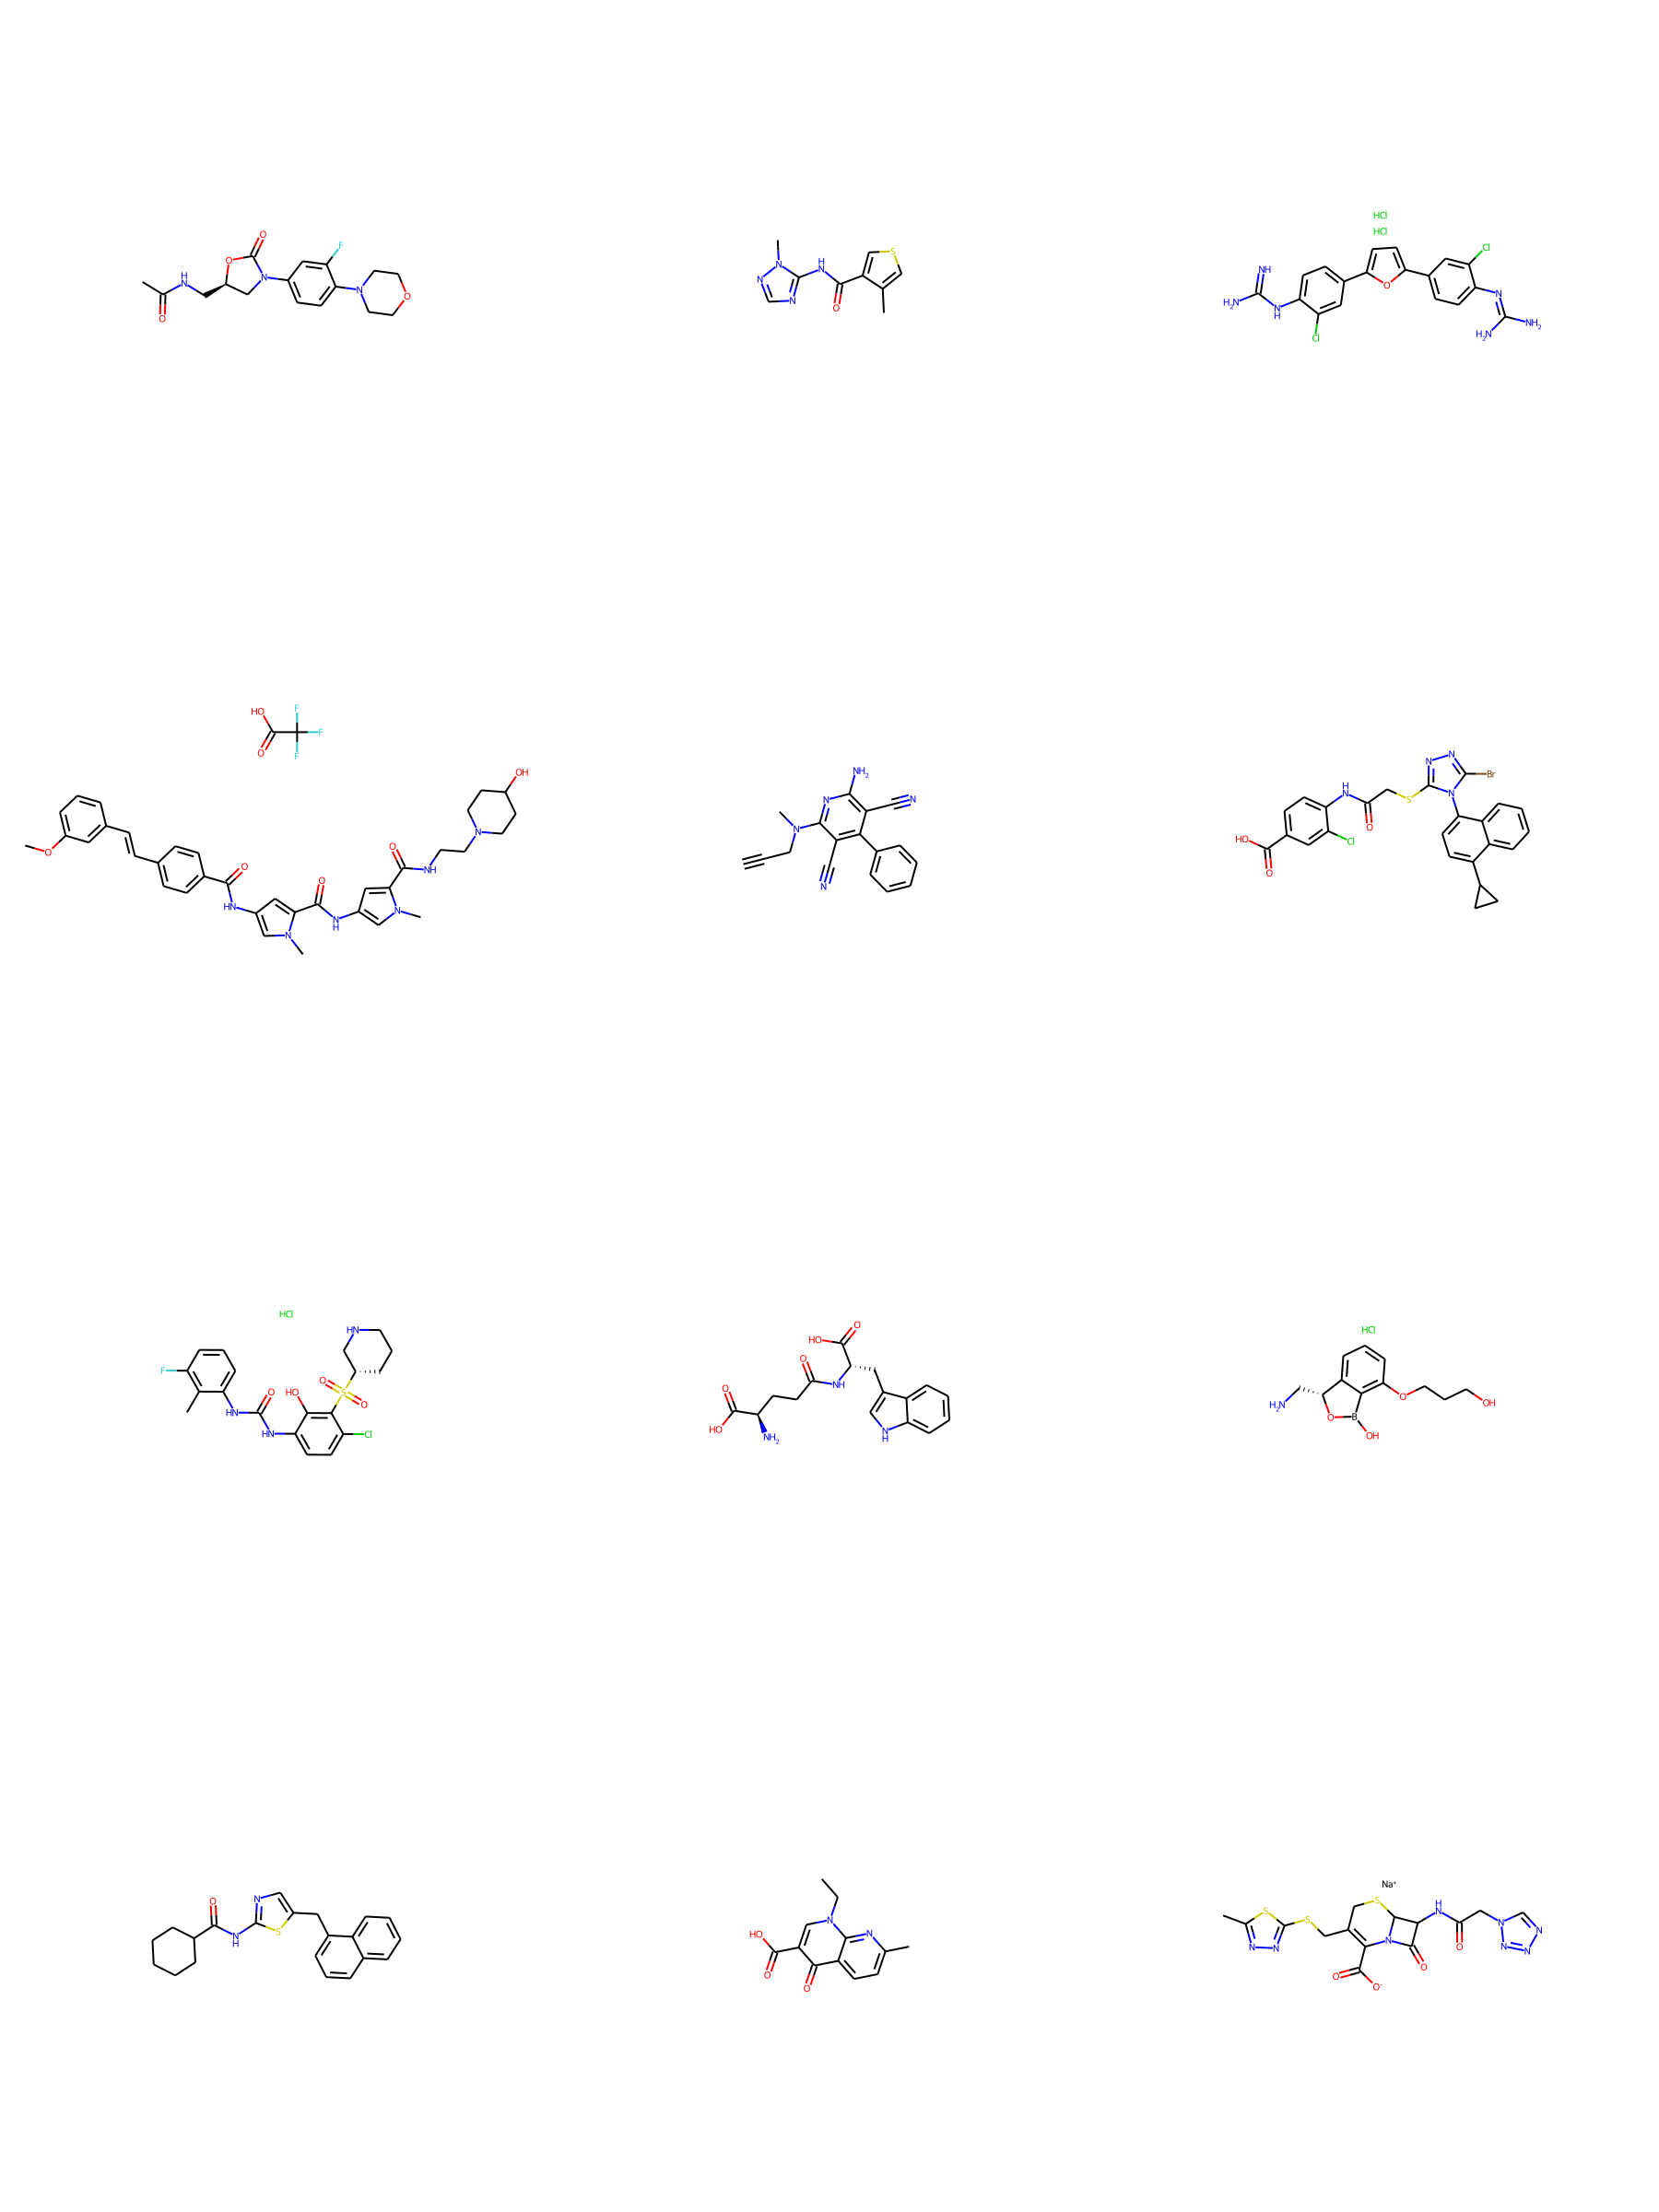

In [3]:
#generate molecules
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools

#generate molecules and fingerprints
PandasTools.AddMoleculeColumnToFrame(pa_data,'Smiles','Molecule')
PandasTools.AddMoleculeColumnToFrame(sa_data,'Smiles','Molecule')
im = PandasTools.FrameToGridImage(pa_data, column='Molecule', maxMols=12, molsPerRow=3,subImgSize=(600,600))
display(im)


In [4]:
#generate fingerprints
import numpy as np
from rdkit.Chem import AllChem
from rdkit import DataStructs

pa_fingerprints_bit = [AllChem.GetMorganFingerprintAsBitVect(m,2,nBits=1024).ToBitString() for m in pa_data["Molecule"]]
pa_fingerprints_array = [np.array([s for s in A], dtype=int) for A in pa_fingerprints_bit]
sa_fingerprints_bit = [AllChem.GetMorganFingerprintAsBitVect(m,2,nBits=1024).ToBitString() for m in sa_data["Molecule"]]
sa_fingerprints_array = [np.array([s for s in A], dtype=int) for A in sa_fingerprints_bit]
pa_data["Fingerprints"] = pa_fingerprints_array
sa_data["Fingerprints"] = sa_fingerprints_array



In [5]:
#test training split
import numpy as np
from sklearn.model_selection import train_test_split

X_pa = np.stack(pa_data.loc[:,"Fingerprints"])
X_sa = np.stack(sa_data.loc[:,"Fingerprints"])
y_pa = pa_data.Active
y_sa = sa_data.Active
X_train_pa, X_test_pa, y_train_pa, y_test_pa = train_test_split(X_pa, y_pa, test_size=0.33, random_state=42)
X_train_sa, X_test_sa, y_train_sa, y_test_sa = train_test_split(X_sa, y_sa, test_size=0.33, random_state=42)

In [6]:
#CVGridSearch
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

log_param_grid = [
  {'loss': ['log'], 'penalty': ['elasticnet'], 'alpha': [0.000001, 0.00001, 0.0001, 0.001], 'l1_ratio': [0,.2,.5,.7,1],'random_state':[1]}
 ]

def GridSearch(score, X_train, y_train, X_test, y_test):
    print("# Tuning hyper-parameters for %s" % score)
    print()
    
    clf = GridSearchCV(SGDClassifier(), log_param_grid, scoring="%s" % score)
    clf.fit(X_train, y_train)
    
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()
    
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test_pa, clf.predict(X_test_pa)
    print(classification_report(y_true, y_pred))
    print()
    
    return clf

pa_classifier = GridSearch("balanced_accuracy", X_train_sa, y_train_sa, X_test_sa, y_test_sa)
    

# Tuning hyper-parameters for balanced_accuracy



C:\Users\Anirudh\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\Anirudh\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\Anirudh\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\Anirudh\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='l

C:\Users\Anirudh\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\Anirudh\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\Anirudh\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\Anirudh\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='l

C:\Users\Anirudh\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\Anirudh\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\Anirudh\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\Anirudh\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='l

C:\Users\Anirudh\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\Anirudh\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\Anirudh\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Best parameters set found on development set:

{'alpha': 1e-05, 'l1_ratio': 0, 'loss': 'log', 'penalty': 'elasticnet', 'random_state': 1}

Grid scores on development set:

0.705 (+/-0.083) for {'alpha': 1e-06, 'l1_ratio': 0, 'loss': 'log', 'penalty': 'elasticnet', 'random_state': 1}
0.715 (+/-0.113) for {'alpha': 1e-06, 'l1_ratio': 0.2, 'loss': 'log', 'penalty': 'elasticnet', 'random_state': 1}
0.702 (+/-0.083) for {'alpha': 1e-06, 'l1_ratio': 0.5, 'loss': 'log', 'penalty': 'elasticnet', 'random_state': 1}
0.695 (+/-0.106) for {'alpha': 1e-06, 'l1_ratio': 0.7, 'loss': 'log', 'penalty': 'elasticnet', 'random_state': 1}
0.708 (+/-0.113) for {'alpha': 1e-06, 'l1_ratio': 1, 'loss': 'log', 'penalty': 'elasticnet', 'random_state': 1}
0.748 (+/-0.123) for {'alpha': 1e-05, 'l1_ratio': 0, 'loss': 'log', 'penalty': 'elasticnet', 'random_state': 1}
0.721 (+/-0.098) for {'alpha': 1e-05, 'l1_ratio': 0.2, 'loss': 'log', 'penalty': 'elasticnet', 'random_state': 1}
0.685 (+/-0.056) for {'alpha': 1e-05

balanced accuracy score: 0.913746


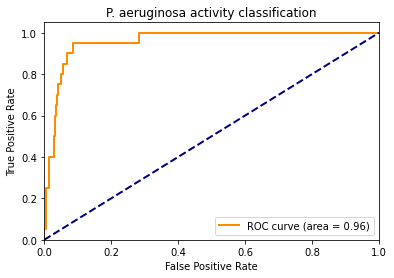

In [7]:
#calculate balanced accuracy and make ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score, balanced_accuracy_score

print("balanced accuracy score: %f" % balanced_accuracy_score(y_test_pa, pa_classifier.predict(X_test_pa)))
fpr_pa, tpr_pa, _ = roc_curve(y_test_pa, pa_classifier.decision_function(X_test_pa))
roc_auc = auc(fpr_pa, tpr_pa)

plt.figure()
lw = 2
plt.plot(
    fpr_pa,
    tpr_pa,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("P. aeruginosa activity classification")
plt.legend(loc="lower right")
plt.show()

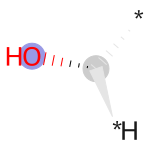

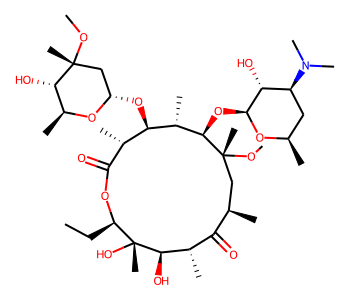

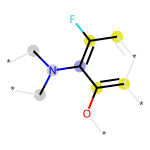

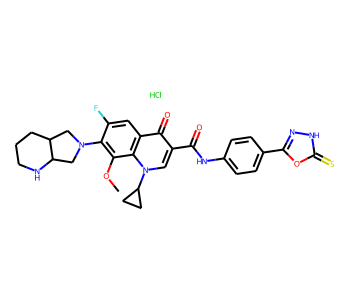

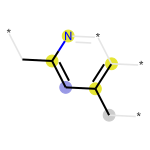

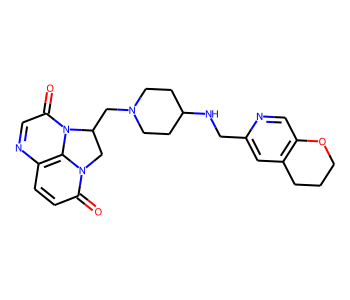

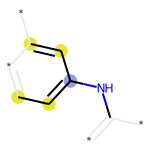

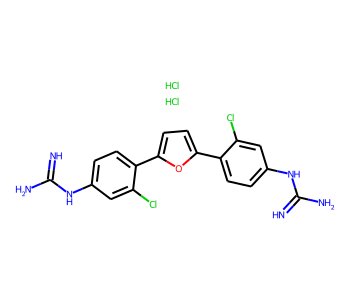

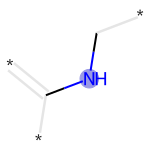

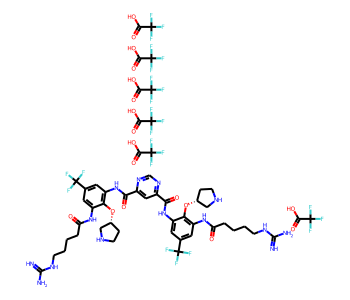

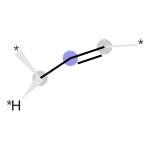

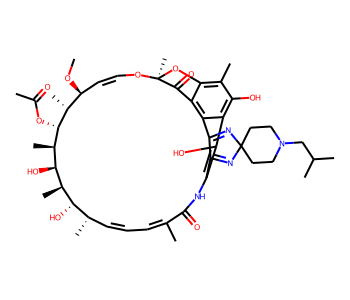

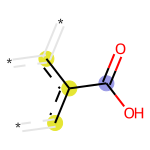

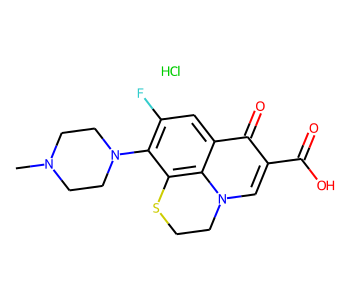

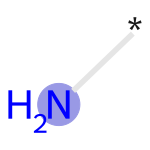

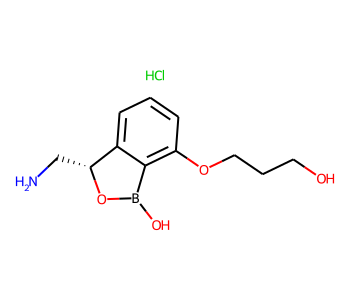

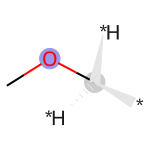

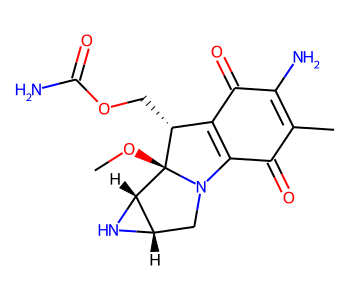

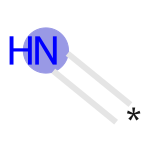

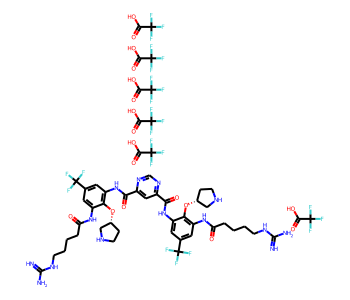

In [8]:
#analyze feature contributions to prediction
from IPython.display import SVG

#get feature coefficients
pa_coeff = pa_classifier.best_estimator_.coef_

#determine how many features have 0 coefficient
num_zero = (pa_coeff == 0).sum()

#sort coefficients
sort_index = np.argsort(-1*pa_coeff[0,:])

#find an active molecule for each of the top five features
molecules_with_features = {}
molecules_fingerprint = {}
all_molecules_with_features = {}
for i in range(0, 10):
    molecules_with_features[i] = []
    all_molecules_with_features[i] = []
    molecules_fingerprint[i] = []
    idx = sort_index[i]
    for j in pa_data.index:
        fingerprint = pa_data.loc[j, "Fingerprints"]
        if fingerprint[idx] == 1 and pa_data.loc[j,"Active"] == 1:
            molecules_with_features[i].append(pa_data.loc[j, "Molecule"])
            molecules_fingerprint[i].append(pa_data.loc[j, "Fingerprints"])
        if fingerprint[idx] == 1 :
            all_molecules_with_features[i].append(pa_data.loc[j, "Molecule"])
    bi = {}
    fp = AllChem.GetMorganFingerprintAsBitVect(molecules_with_features[i][0], radius=2, bitInfo=bi,nBits=1024)
    mfp2_svg = Draw.DrawMorganBit(molecules_with_features[i][0], idx, bi, useSVG=True)
    display(mfp2_svg)
    molecule_svg = Draw.rdMolDraw2D.MolDraw2DSVG(350,300)
    molecule_svg.DrawMolecule(molecules_with_features[i][0])
    molecule_svg.FinishDrawing()
    molecule_drawing =SVG(molecule_svg.GetDrawingText())
    display(molecule_drawing)

# Tuning hyper-parameters for balanced_accuracy



C:\Users\Anirudh\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\Anirudh\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\Anirudh\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\Anirudh\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='l

C:\Users\Anirudh\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\Anirudh\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\Anirudh\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\Anirudh\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='l

C:\Users\Anirudh\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\Anirudh\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\Anirudh\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\Anirudh\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='l

Best parameters set found on development set:

{'alpha': 1e-06, 'l1_ratio': 0.7, 'loss': 'log', 'penalty': 'elasticnet', 'random_state': 1}

Grid scores on development set:

0.668 (+/-0.210) for {'alpha': 1e-06, 'l1_ratio': 0, 'loss': 'log', 'penalty': 'elasticnet', 'random_state': 1}
0.679 (+/-0.167) for {'alpha': 1e-06, 'l1_ratio': 0.2, 'loss': 'log', 'penalty': 'elasticnet', 'random_state': 1}
0.682 (+/-0.161) for {'alpha': 1e-06, 'l1_ratio': 0.5, 'loss': 'log', 'penalty': 'elasticnet', 'random_state': 1}
0.712 (+/-0.150) for {'alpha': 1e-06, 'l1_ratio': 0.7, 'loss': 'log', 'penalty': 'elasticnet', 'random_state': 1}
0.665 (+/-0.186) for {'alpha': 1e-06, 'l1_ratio': 1, 'loss': 'log', 'penalty': 'elasticnet', 'random_state': 1}
0.684 (+/-0.164) for {'alpha': 1e-05, 'l1_ratio': 0, 'loss': 'log', 'penalty': 'elasticnet', 'random_state': 1}
0.649 (+/-0.093) for {'alpha': 1e-05, 'l1_ratio': 0.2, 'loss': 'log', 'penalty': 'elasticnet', 'random_state': 1}
0.651 (+/-0.109) for {'alpha': 1e-

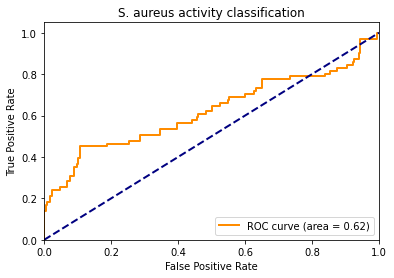

In [9]:
sa_classifier = GridSearch("balanced_accuracy", X_train_pa, y_train_pa, X_test_pa, y_test_pa)

print("balanced accuracy score: %f" % balanced_accuracy_score(y_test_sa, sa_classifier.predict(X_test_sa)))
fpr_sa, tpr_sa, _ = roc_curve(y_test_sa, sa_classifier.decision_function(X_test_sa))
roc_auc = auc(fpr_sa, tpr_sa)

plt.figure()
lw = 2
plt.plot(
    fpr_sa,
    tpr_sa,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("S. aureus activity classification")
plt.legend(loc="lower right")
plt.show()

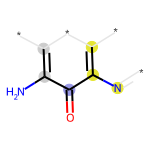

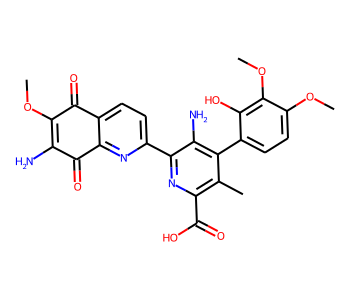

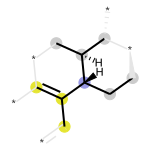

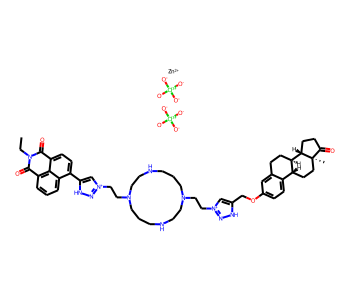

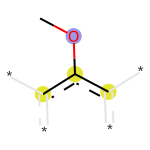

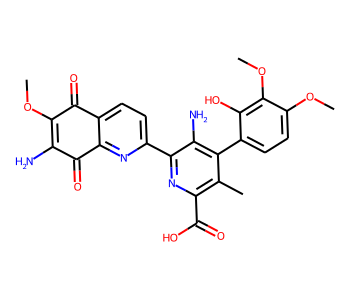

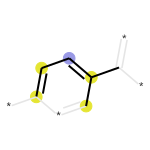

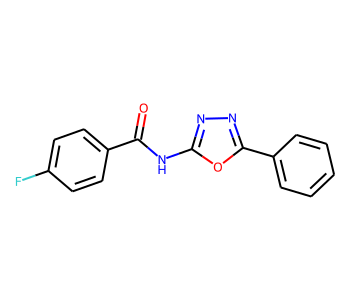

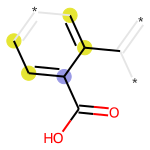

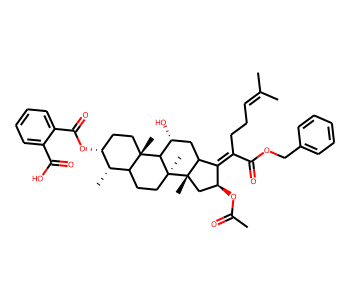

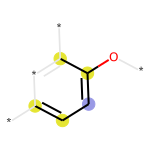

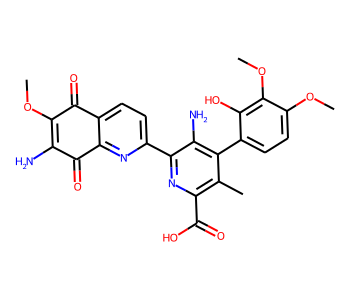

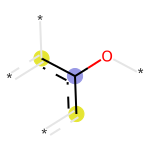

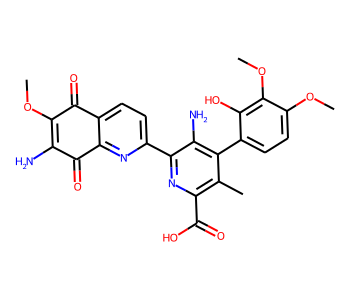

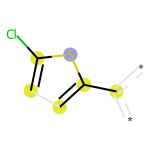

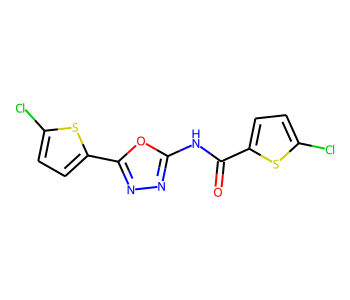

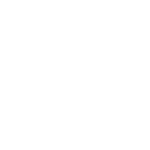

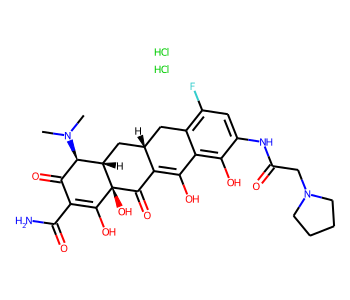

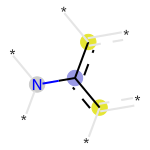

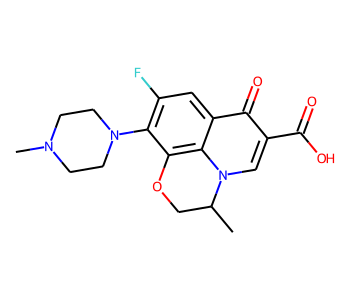

In [10]:
#get feature coefficients
sa_coeff = sa_classifier.best_estimator_.coef_

#determine how many features have 0 coefficient
num_zero = (sa_coeff == 0).sum()

#sort coefficients
sort_index = np.argsort(-1*sa_coeff[0,:])

#find an active molecule for each of the top five features
molecules_with_features = {}
molecules_fingerprint = {}
all_molecules_with_features = {}
for i in range(0, 10):
    molecules_with_features[i] = []
    all_molecules_with_features[i] = []
    molecules_fingerprint[i] = []
    idx = sort_index[i]
    for j in sa_data.index:
        fingerprint = sa_data.loc[j, "Fingerprints"]
        if fingerprint[idx] == 1 and sa_data.loc[j,"Active"] == 1:
            molecules_with_features[i].append(sa_data.loc[j, "Molecule"])
            molecules_fingerprint[i].append(sa_data.loc[j, "Fingerprints"])
        if fingerprint[idx] == 1 :
            all_molecules_with_features[i].append(sa_data.loc[j, "Molecule"])
    bi = {}
    fp = AllChem.GetMorganFingerprintAsBitVect(molecules_with_features[i][0], radius=2, bitInfo=bi,nBits=1024)
    mfp2_svg = Draw.DrawMorganBit(molecules_with_features[i][0], idx, bi, useSVG=True)
    display(mfp2_svg)
    molecule_svg = Draw.rdMolDraw2D.MolDraw2DSVG(350,300)
    molecule_svg.DrawMolecule(molecules_with_features[i][0])
    molecule_svg.FinishDrawing()
    molecule_drawing = SVG(molecule_svg.GetDrawingText())
    display(molecule_drawing)